### Matthieu Souda, Gaëtan Narozniak & Auguste Crabeil

# Sampling for generative models - Project

In the following notebook, we introduce our exploration of [Monte Carlo guided Diffusion for Bayesian linear inverse problems](https://arxiv.org/pdf/2308.07983), by Cardoso et al. (2023). We chose an implementative approach : after introducing the context and the main contributions of the paper, we will implement it and show some of its applications on chosen data.

# 1. Introduction - context and existing approaches

## 1.1 Linear inverse problems
The presented approach is designed to solve linear inverse problems, which are common in various fields such as various types of imaging or image restoration. It can be described with the following equation:
$$
y = Ax + \epsilon
$$
where:
- $y\in \mathbb{R}^{d_y}$ is the observed data
- $A\in \mathbb{R}^{d_y}\times\mathbb{R}^{d_x}$ is the forward operator (a linear operator that maps the unknown variable $x$ to the observed data $y$)
- $x\in \mathbb{R}^{d_x}$ is the unknown variable we want to estimate (the signal we want to recover)
- $\epsilon\in \mathbb{R}^{d_y}$ is the noise in the observations

We aim to recover $x$ from the observed data $y$. This is obviously a task diffusion looks suited for, as it is a generative model that can learn the distribution of the data and generate samples from it, and can base itself on Bayes formula to estimate the posterior distribution of $x$ given $y$, making a statistical formulation of the inverse problem.

## 1.2 Existing approaches
The main and earliest approaches to sove linear inverse problems attempt regularized minimization of the following cost function:
$$
\frac{1}{2}\|Ax - y\|^2 + \lambda R(x)
$$
which we know how to solve efficiently and that takes into account the noise in the observations. The main difficulties here are the assumptions we have to make on the data $x$ (smoothness, geometric properties, etc.) and the choice of the regularization. 

After those problems were formulated as statistical ones, making $x$, $y$ and $\epsilon$ random variables, the Bayesian approach was introduced. It consists in estimating the posterior distribution of $x$ given $y$, which is given by Bayes formula:
$$
p(x|y) \propto p(y|x)p(x)
$$
where $p(y|x)$ is the likelihood and $p(x)$ is the prior distribution of $x$. 
Such Bayesian problems can be solved using non-DL methods such as mixtures, or DL methods including GANs, VAEs, or diffusion models. The latter proved to be particularly useful and efficient, as it is does not require specific training regarding the restoration of the data.

Existing diffusion-based approaches aim to diffuse noisy degraded observations forward under probability $q(x_{t+1}|x_t)$ then propagate backward to generate $x$ samples by estimating the noise $\epsilon$ with neural networks, under probability $p_{\theta}(x_t|x_{t+1})$. Among major approaches, we can cite:
- DDRM (Denoising Diffusion Restoration Model) [1] : the main point is to tie the noise inside the backward diffusion process with the noise in the observations $y$ at each step, and making the reconstructed data a weighted sum of the noisy observations and the prediction. 
- DPS (Denoising Probabilistic Score) [2] : this score-based approach aim to retrieve the posterior by expressing its score as a function of the leanred score estimate of the prior.
- SCMDiff (Score-based Conditional Monte Carlo Diffusion) [3] : especially suited for solving the inpainting problem, it estimates the conditional distribution of the missing part we want to impute, given the fowrad process trajectory of the observed part, but using a Sequential Monte-Carlo method to produce particles that approximate the posterior distribution.

DDRM and DPS present a major drawback: they do not always produce samples consistent with the posterior, even if they capture well the prior, and thus cannot be used to sample the posterior distribution. SCMDiff is a promising approach, but it is limited to the inpainting problem and requires a large number of particles to approximate the posterior distribution, and also needs strong assumptions on the data distribution, such as that forward and backward processes use equal probability laws, meaning $q(x_t|x_{t+1}) = p_{\theta}(x_t|x_{t+1})$, which is not always the case.

# 2 MCGDiff - method and contributions

## 2.1 Preliminaries - from inpainting to general linear inverse problems

The paper first states that solving the general linear inverse problem is equivalent to solving the inpainting problem, where $Y$ is the noisy observation of some part of the coordinates of $X$, and where we want to estimate the missing part of $X$ given $Y$. It is enough to use the singular value decomposition of the forward operator $A$ to obtain the inpainting problem. The inpainting problem is described as : 
$$
Y = \bar{X} + \sigma_y\epsilon
$$
where $\bar{X}$ is the part of the true data along the coordinates we observed in $Y$ and $\epsilon$ is a standard Gaussian noise. Denoting $\underline{X}$ the part of the data we want to estimate, we have $X = \bar{X}^{\frown} \underline{X}$, where $^\frown$ is the concatenation operator. 
For the general case, using $A = US V^T$, $S$ diagonal, $U$ and $V$ orthogonal, we have:
$$
\mathbf{Y} = \bar{\mathbf{X}} + \sigma_y S^{-1}\tilde{\epsilon}
$$
with $\mathbf{Y} = S^{-1}U^TY$, $\mathbf{X} = V^TX$ and $\tilde{\epsilon} = U^T\epsilon$ a standard Gaussian noise, back to kind of an inpainting problem.

The method is then described for the inpainting problem. Also, it starts with the noiseless case ($\sigma_y = 0$), and then extends it to the noisy case.

## 2.2 MCGDiff - method

The method is based on the following idea, called "particle filter": we sequentially sample particles conditionally to previous ones and observation $Y$, and we use those particles to approximate the posterior distribution at each backward step. Those particles are $N$ Monte Carlo Samples denoted $\xi_t^i$ at backward step $t \in [0,n]$ and $i \in [1,N]$, and are applied a Markov transition $p_t^y$ to obtain a particle approximation of the posterior distribution at each step $t$, denoted $\hat{\phi}_t^N(x_t)$. The filtering operation happens at the final estimation step, when ancestors particles are sampled from $\xi_t^{I_t^i}$, sampling most promising indices $I_t$ from categorical distribution proportional to a weight function $\tilde{w}_t^i$ that is a updated at each step. The estimation $\hat{\phi}_t^N$ is then a Monte Carlo approximation of $\xi_t^{I_t^i}$, a mean of Dirac masses at each $\xi_t^{I_t^i}$. Let's note that in the noiseless case, this filtering and sequential update is equivalent to a single backward diffusion process, and requires the choice of a schedule and usual sequence of $\beta_t$ values and corresponding $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s=\prod_{s=1}^t (1 - \beta_s)$ as well as noise levels $\sigma_t$ for sequential updates. Those parameters control equivalent forward process transitions $q(x_t|x_{t+1})$; the weight function is updated according to both backward and forward transitions on the observed part of the coordinates $\bar{p}_t$ and $\bar{q}_t$:
$$
\tilde{w}_t(x_{t+1}) = \frac{\int \bar{p}_t(\bar{x}_{t}|x_{t+1})\bar{q}_{t|0}(\bar{x_t}|y)dx_t}{\bar{q}_{t+1|0}(\bar{x}_{t+1}|y)} \text{  with } \bar{q}_{t|0}(\bar{x_t}|y) = \mathcal{N}(\bar{x_t}; \bar{\alpha}_t^{1/2}y, (1-\bar{\alpha}_t)I) \text{  being the classic forward sequence of potentials.}
$$
This update allows to sample the most promising particles at each step, guiding the approximation through the Markov backward process $p^y_s$ accordingly to the forward process $q$, consistently with the diffused observed part of the data at each step $t$. This is motivated by the fact that the posterior $\phi_t^y(x_t)$ is then defined as : 
$$
\phi_t^y(x_t) \propto \int p_t(x_{t}|x_{t+1})\frac{\bar{q}_{t|0}(\bar{x_t}|y)dx_t}{\bar{q}_{t+1|0}(\bar{x}_{t+1}|y)}\phi_{t+1}^y(dx_{t+1})
$$
and that the previously described $\hat{\phi}_0^N(x_t)$, obtained through sequential updates of particles and of the weight function, converges towards the posterior $\phi_0^y(x_0)$ as $N$ increases.

This design is shown to obtain convergence under almost no assumption, just that posteriors $\phi_t^y(x_t)$ are well defined, meaning the integrated distribution quotient $\frac{\bar{q}_{t|0}(\bar{x_t}|y)}{\bar{q}_{t+1|0}(\bar{x}_{t+1}|y)}$ is in fact integrable. This is a major advantage over existing approaches, which require strong assumptions on the data distribution and the forward and backward processes, which often don't hold in practice.

In the **noisy** case ($\sigma_y > 0$), the method is applied to filter and approximate posterior $\phi_{\tau}^y(x_{\tau})$, $\tau$ chosen such as $y_{tau}$ is a noiseless observation of $y$ (which is possible with a large enough number of steps). We then propagate backward the posterior to time 0 using backward kernel $p_{\tau|0}$ and the forward kernel $q_{\tau|0}$.

## 2.3 MCGDiff - contributions

- MCGDiff proved to be such a versatile method, dealing with general inverse problems, by targeting the posterior distribution quite undependently of the type of problem, and getting computational benefit from Sequential Monte Carlo samplers. 
- The consistency of the results is guaranteed by the proposed guidnance in particle filtering, using forward sequence of potentials to guide the backward process. The process may seem complex, but the existence of this general principle in the process (e.g. in the update of the weight function) allows great versatility and consistency when applying the method to various problems, especially compared to existing approaches such as DPS, DDRM or SMCDiff.
- The assumptions on the data distribution are very weak, and the method is shown to be consistent under almost no assumption, which is a major advantage over existing approaches.


# 3. Implementation of the method

In [1]:
# all the needed import
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Categorical
from torch.optim import AdamW
import matplotlib.pyplot as plt

## 3.1 Implementation of DDPM and MCGDiff on a simple dataset

We start with the complete implementation of DDPM and MCGDiff on a simple 2D dataset. The goal is to see if after the training of our diffusion model, we are able to solve a simple inpainting problem with our MCGDiff.

### 3.1.1 A simple DDPM

The dataset and model for our DDPM are taken from [this github project](https://github.com/tanelp/tiny-diffusion). The dataset consists of a simple Gaussian mixture centered around various points to form the shape of a dinosaur (it's easier to learn a Gaussian mixture than a set of Dirac distributions).

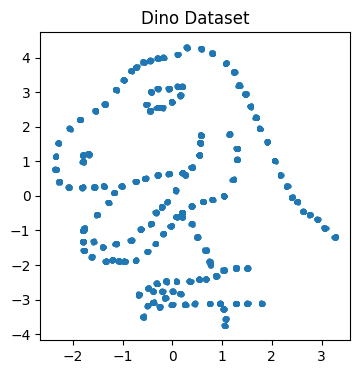

In [2]:
def dino_dataset(n=8000):
    df = pd.read_csv("datasaurus.csv")
    df = df[df["dataset"] == "dino"]
    rng = np.random.default_rng(42)
    ix = rng.integers(0, len(df), n)
    x = df["x"].iloc[ix].tolist()
    x = np.array(x) + rng.normal(size=len(x)) * 0.15
    y = df["y"].iloc[ix].tolist()
    y = np.array(y) + rng.normal(size=len(x)) * 0.15
    x = (x/54 - 1) * 4
    y = (y/48 - 1) * 4
    X = np.stack((x, y), axis=1)
    return TensorDataset(torch.from_numpy(X.astype(np.float32)))

dataset = dino_dataset()

plt.figure(figsize=(4, 4))
plt.scatter(dataset.tensors[0][:, 0], dataset.tensors[0][:, 1], s=5)
plt.title("Dino Dataset")
plt.show()

In [3]:
class SinusoidalEmbedding(nn.Module):
    def __init__(self, size: int, scale: float = 1.0):
        super().__init__()
        self.size = size
        self.scale = scale

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = torch.log(torch.Tensor([10000.0])) / (half_size - 1)
        emb = torch.exp(-emb * torch.arange(half_size))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb
    
    def __len__(self):
        return self.size
    
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128):
        super().__init__()

        self.time_mlp = SinusoidalEmbedding(emb_size)
        self.input_mlp1 = SinusoidalEmbedding(emb_size, scale=25.0)
        self.input_mlp2 = SinusoidalEmbedding(emb_size, scale=25.0)

        concat_size = len(self.time_mlp) + \
            len(self.input_mlp1) + len(self.input_mlp2)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        t = t.squeeze(1)
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

Now that we have a dataset and a model, we reimplement the algorithm presented in the original DDPM paper [4] to train our model to learn the distribution of the dinosaur.

In [4]:
class DDPM():
    def __init__(self, n: int, net: nn.Module, input_shape):
        """
        n: number of timesteps
        input_shape: shape of one sample
        """
        self.n = n
        self.betas = torch.linspace(0, 0.02, n+1) 
        self.alphas = 1-self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sigmas = torch.sqrt(self.betas)
        self.net = net
        self.input_shape = input_shape

    # train the model just like in the DDPM paper
    def train(self, loader, n_epochs):
        epoch_loss = []
        optimizer = AdamW(self.net.parameters())
        for e in range(n_epochs):
            lossi = []
            for batch in loader:
                X = batch[0] # (batch_size, ...)
                t = torch.randint(1, self.n, (X.shape[0],1))
                noise = torch.randn_like(X) 
                X_noised = torch.sqrt(self.alpha_bars[t])*X + \
                    torch.sqrt(1-self.alpha_bars[t])*noise
                out = self.net(X_noised, t)
                assert out.shape == noise.shape, f"{out.shape = }, {noise.shape = }"
                loss = torch.mean((out - noise)**2)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                lossi.append(loss.item())
            if e % 50 == 0:
                print(f"epoch {e}: mean loss = {np.mean(lossi)}")
            epoch_loss.append(np.mean(lossi))
        plt.plot(epoch_loss)
    
    # sample n_samples of the distribution given the model trained (reverse process) and return all the intermediate steps
    def sample_evolution(self, n_samples):
        x = torch.randn((n_samples,) + self.input_shape)
        list_samples = [x]
        for t in range(self.n, 0, -1):
            noise = torch.randn_like(x)
            timesteps = torch.full((n_samples, 1), t)
            noise_pred = self.net(x, timesteps) * self.betas[t]/torch.sqrt(1-self.alpha_bars[t])
            x = (x - noise_pred)/torch.sqrt(self.alphas[t]) + self.sigmas[t] * noise
            list_samples.append(x)
        list_samples = torch.stack(list_samples)
        return list_samples
    
    # predict the mean and noise used in the reverse step at time t (used for MCGDiff)
    def predict(self, particles, t):
        noise = (((1 - self.alpha_bars[t]) / (1 - self.alpha_bars[t+1])) * (1 - self.alpha_bars[t+1] / self.alpha_bars[t]))**.5
        coeff_sample = (self.alpha_bars[t] / self.alpha_bars[t+1])**.5
        coeff_score = ((1 - self.alpha_bars[t] - noise**2)**.5) - coeff_sample * ((1 - self.alpha_bars[t+1])**.5)

        timesteps = torch.full((particles.shape[0], 1), t)
        epsilon_predicted = self.net(particles, timesteps)
        mean = coeff_sample * particles + coeff_score * epsilon_predicted
        return mean, noise

epoch 0: mean loss = 0.772502157330513
epoch 50: mean loss = 0.64293732047081
epoch 100: mean loss = 0.6291180307865143
epoch 150: mean loss = 0.6293380410671234
epoch 200: mean loss = 0.6370024119615555
epoch 250: mean loss = 0.6141550869941711


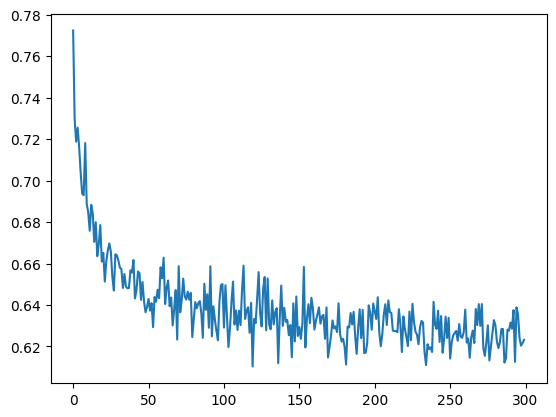

In [5]:
net = MLP(hidden_size=128, hidden_layers=3, emb_size=128)
ddpm = DDPM(200, net, (2,))

loader = DataLoader(dataset, batch_size=32, shuffle=True)
ddpm.train(loader, 300)

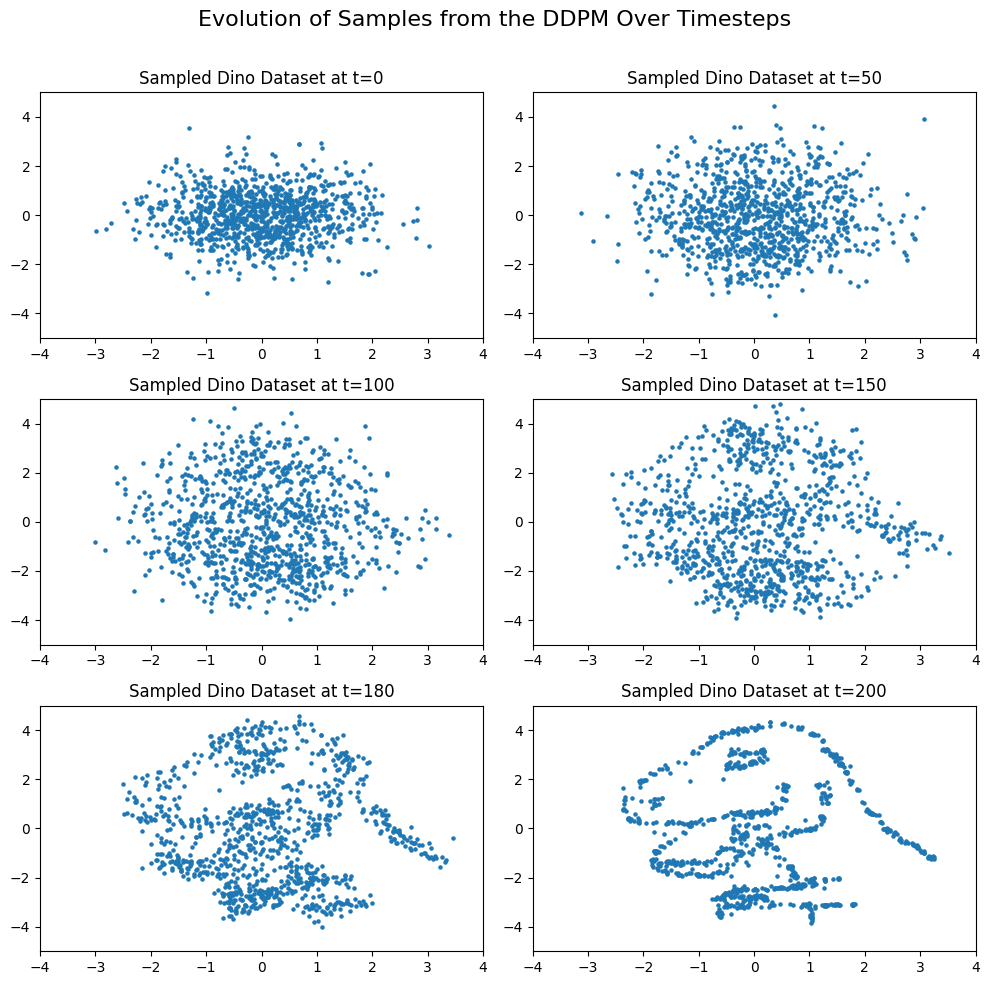

In [6]:
list_samples = ddpm.sample_evolution(1000).detach().numpy()
timesteps = [0, 50, 100, 150, 180, 200]

plt.figure(figsize=(10, 10))
for i, t in enumerate(timesteps):
    plt.subplot(3, 2, i + 1)
    plt.scatter(list_samples[t][:, 0], list_samples[t][:, 1], s=5)
    plt.title(f"Sampled Dino Dataset at t={t}")
    plt.xlim(-4, 4)
    plt.ylim(-5, 5)

plt.suptitle("Evolution of Samples from the DDPM Over Timesteps", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

We now have a DDPM algorithm that can sample from the dinosaur distribution!

### 3.1.2 MGCDiff in the noiseless case for simple inpainting

To better understand the algorithm, we decided to create a very simple example illustrating a use case of MCGDiff. We fix the first coordinate of some points and use the MCGDiff algorithm to generate 2D points from the dinosaur distribution that match this specific first coordinate. This corresponds to the simple inpainting task in the noiseless case described in Section 2, where $y = \bar{x}$. To solve this problem, we implement Algorithm 1 from the paper [Monte Carlo Guided Diffusion for Bayesian Linear Inverse Problems](https://arxiv.org/pdf/2308.07983).

In [7]:
def log_likelihood(x, mean, std): # Compute the log-likelihood of x given mean and std (gaussian distribution)
    return - 1/2 * torch.sum((x - mean)**2 / std, dim=1)

def mcgdiff(ddpm, y, dx, N, n): # Perform the MCGDiff algorithm in the noiseless case
    """
    ddpm : The DDPM model.
    y : the incomplete observation.
    dx : Dimension of x. 
    N : The number of samples to generate.
    n : The number of diffusion steps.
    """
    alpha_bars = ddpm.alpha_bars
    dy = len(y)
    particles = torch.zeros((n + 1, N, dx))
    particles[-1, :, :] = torch.randn((N, dx))

    for i in range(n - 1, 0, -1):
        mean, noise = ddpm.predict(particles[i + 1], i)
        log_weights = log_likelihood(alpha_bars[i]**.5 * y, mean[:,:dy], noise**2 + 1 - alpha_bars[i]) - log_likelihood(alpha_bars[i + 1]**.5 * y, particles[i + 1][:,:dy], 1 - alpha_bars[i + 1])
        I = Categorical(logits=log_weights).sample((N,))
        z_y = torch.randn((N, dy))
        z_x = torch.randn((N, dx - dy))
        K = noise ** 2 / (noise ** 2 + 1 - alpha_bars[i])
        particles[i, :, :dy] = K * alpha_bars[i]**.5 * y + (1 - K) * mean[:,:dy] + (1 - alpha_bars[i])**.5 * K**.5 * z_y
        particles[i, :, dy:] = mean[:,dy:] + noise * z_x
        particles[i] = particles[i][I]
    return particles

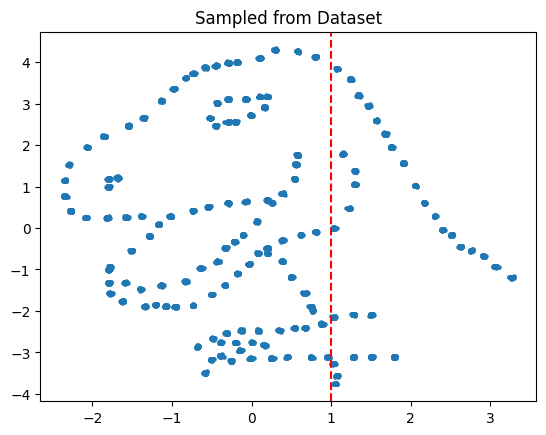

In [17]:
# we choose a first coordinate
y = 1
plt.scatter(dataset.tensors[0][:, 0], dataset.tensors[0][:, 1], s=5)
plt.axvline(y, color='r', linestyle='--')
plt.title("Sampled from Dataset")
plt.show()
y = torch.tensor(y).unsqueeze(0)

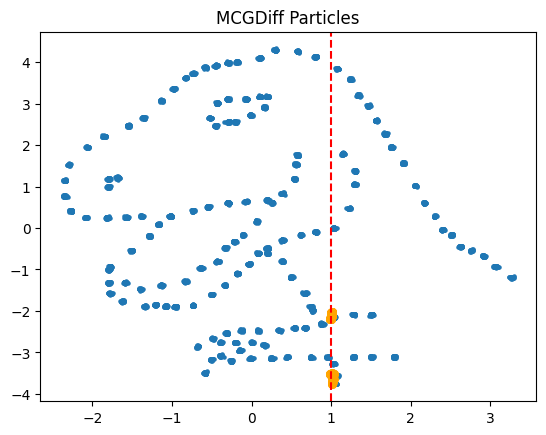

In [19]:
# we generate our particules with this specific first coordinate
particles = mcgdiff(ddpm, y, 2, 100, 200).detach().numpy()
plt.scatter(dataset.tensors[0][:, 0], dataset.tensors[0][:, 1], s=5)
plt.scatter(particles[1,:,0], particles[1,:,1], s=30, color='orange')
plt.axvline(y.numpy(), color='r', linestyle='--')
plt.title("MCGDiff Particles")
plt.show()

We are able to generate samples from the dinosaur distribution that match the desired first coordinate. To better understand how the algorithm works, we visualize the evolution of the particles throughout the sampling process. This allows us to observe how the particles progressively align with both the target distribution and the imposed constraint. During this process, particles that do not match the condition tend to vanish, while those that do are duplicated and propagated — resembling the behavior of an evolutionary algorithm.

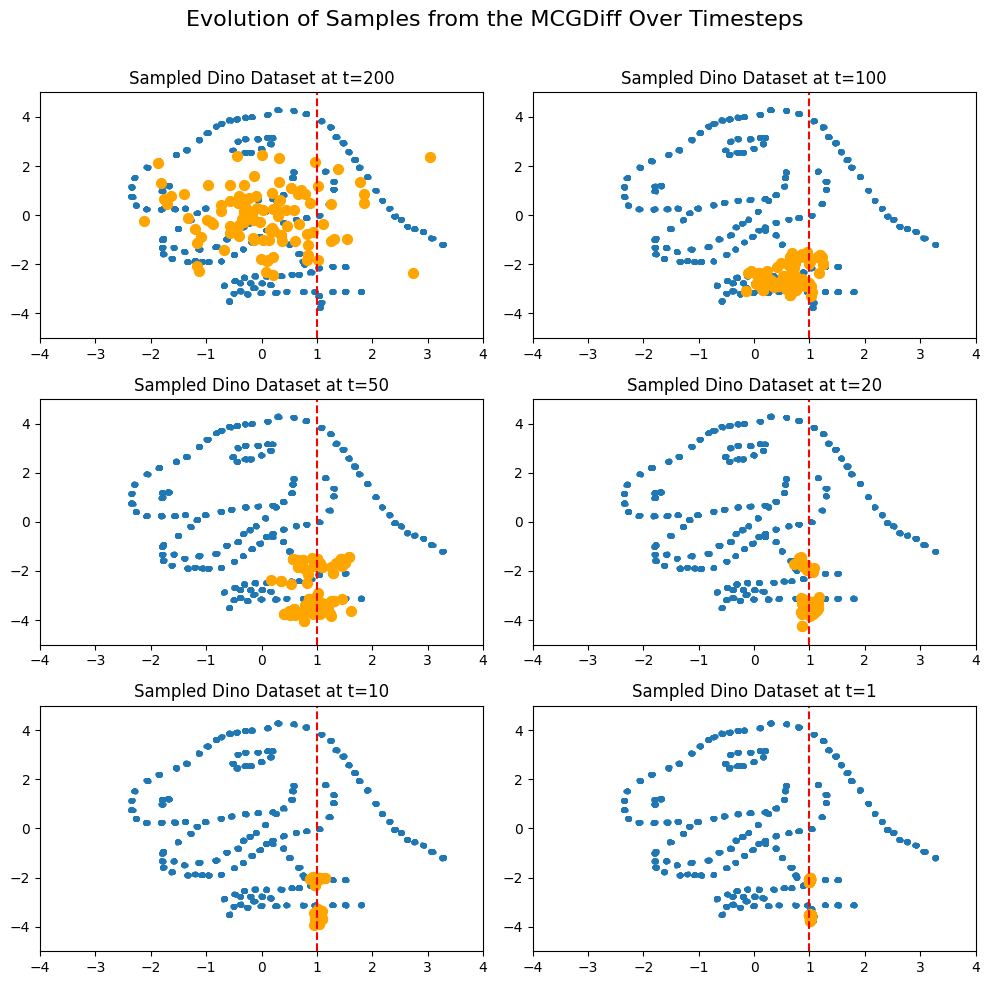

In [20]:
timesteps = [200, 100, 50, 20, 10, 1]
plt.figure(figsize=(10, 10))
for i, t in enumerate(timesteps):
    plt.subplot(3, 2, i + 1)
    plt.scatter(dataset.tensors[0][:, 0], dataset.tensors[0][:, 1], s=5)
    plt.scatter(particles[t][:, 0], particles[t][:, 1], s=50, color='orange')
    plt.axvline(y.numpy(), color='r', linestyle='--')
    plt.title(f"Sampled Dino Dataset at t={t}")
    plt.xlim(-4, 4)
    plt.ylim(-5, 5)

plt.suptitle("Evolution of Samples from the MCGDiff Over Timesteps", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## References
[1] Denoising diffusion restoration models, Kawar et al. (2022) <br>
[2] Diffusion posterior sampling for general noisy inverse problems, Chung et al. (2023) <br>
[3] Diffusion probabilistic modeling of protein backbones in 3d for the motif-scaffolding problem, Trippe et al. (2023) <br>
[4] Denoising Diffusion Probabilistic Models, Ho et al. (2020)